# Apziva Project 1 - Happy Customers

#### Background:

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. From operational standpoint we have been facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

#### Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers <br/>
X1 = my order was delivered on time  <br/>
X2 = contents of my order was as I expected  <br/>
X3 = I ordered everything I wanted to order <br/>
X4 = I paid a good price for my order <br/>
X5 = I am satisfied with my courier <br/>
X6 = the app makes ordering easy for me <br/>

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

### Data Wrangling and EDA

In [4]:
# First, let's import the necessary libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
import warnings
%matplotlib inline

In [5]:
# Now we need to upload the data and understand its properties:
C_data=pd.read_csv('ACME_Data.csv')
C_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [6]:
#Now let's check the data for missing values and data types
C_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


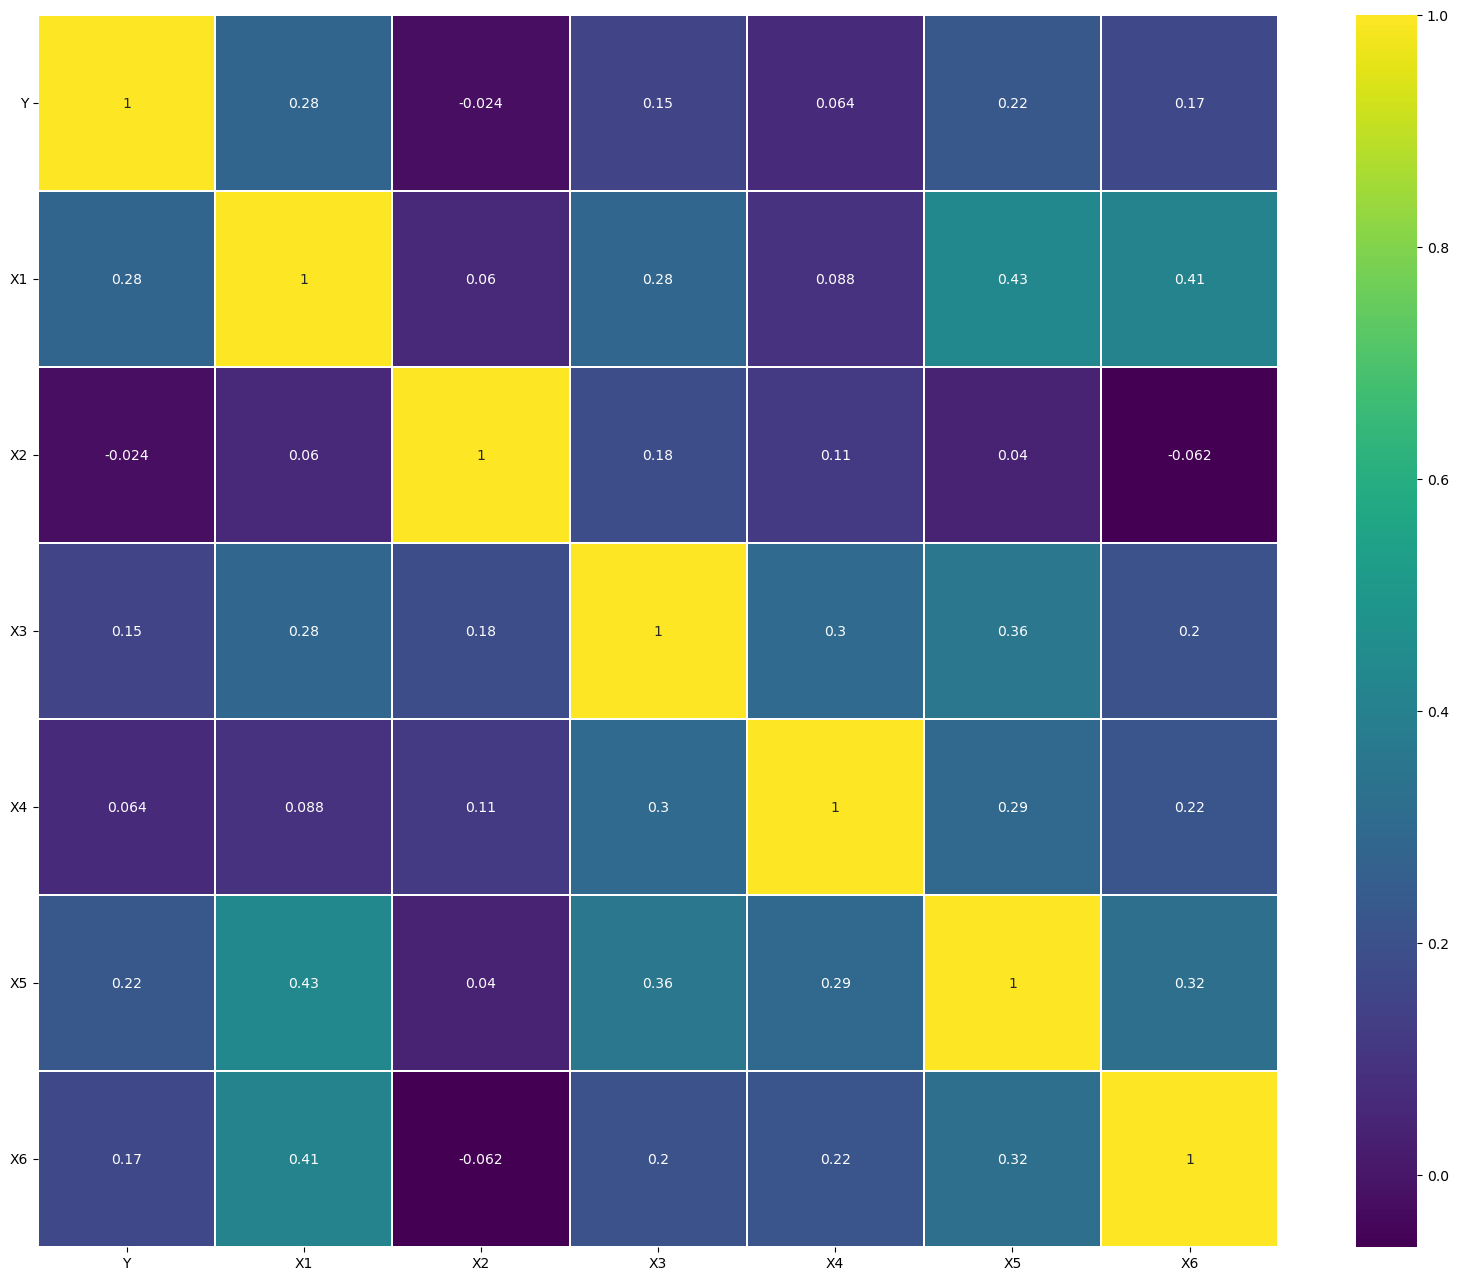

In [7]:
#As we can see we don't have any missing values and all of our columns are integers 
#Since our columns are integers, we can check their correlation with the target column 'Y' and with each other using a heatplot.
plt.figure(figsize=(20,16))
sns.heatmap(C_data.corr(), linewidth=.1, annot=True, cmap='viridis')
plt.yticks(rotation=0)
plt.show()

The heatmap shows that no particular column has a strong correlation with the target column 'Y'. But if we choose one column showing the highest correlation out of all, it would be X1 ('my order was delivered on time'), which makes sense, since for most customers, ordering online, on-time delivery is a priority. <br/>
The feature X2 ('contents of my order was as I expected'), on the other hand, shows slightly negative correlation with the target column, which seems odd but can be explained by the small size of the data. <br/>
It's worth mentioning that X1 ('my order was delivered on time') also has a moderate correlation with X5 ('I am satisfied with my courier') and X6 ('the app makes ordering easy for me'). The correlation between X1 and X5 seems logical, since both rankings belong to the delivery category and the customer who is satisfied with the delivery time is prone to also be satisfied with the courier's service. But the correlation between X1 and X6 doesn't seem to be cause and effect relationship. They just might be two different things that customers appreciate more than other categories. And again, the limited data also affects the correlation coefficents.

Before we move to modeling section of the project, let's do some feature engineering by pairing features with higher correlations, adding the average rating and the rating variance as additional features.

So, the features X1 and X5 have a moderate correlation. Next, there is a positive relationship between the features X3 and X4. And lastly, we'll pair features X2 and X6.

In [11]:
#paired features
C_data['X1_X5'] = C_data['X1'] * C_data['X5']
C_data['X3_X4'] = C_data['X3'] * C_data['X4']
C_data['X2_X6'] = C_data['X2'] * C_data['X6']

# Calculate average rating
C_data['avg_rating'] =C_data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].mean(axis=1)

# Calculate rating variance
C_data['rating_variance'] = C_data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].var(axis=1)

### Modeling

In [13]:
#Let's first divide our data into training and test subsets
X = C_data.drop(columns='Y')
y = C_data['Y']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

Since the data doesn't have any missing values and doesn't require any preprocessing, let's go ahead and start the modeling. Let's start with the Logistic Regression.

In [15]:
#Before modeling let's take a look at our test set target value distribution.
y_test.value_counts()

Y
0    15
1    11
Name: count, dtype: int64

In [16]:
# It looks like the target column is pretty equally distributed.
#Now let's create our Logistic Regression model
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train.values.ravel())
y_pred=lr.predict(X_test)
train_score=lr.score(X_train, y_train)
test_score=lr.score(X_test, y_test)
f1 = f1_score(y_test, y_pred)

print("The accuracy of the Logistic Regression model on the training data is : {}".format(train_score))
print("The accuracy of the Logistic Regression model on the test data is : {}".format(test_score))
print('The F1 score of the Decision Trees model on the test data is : {}:'.format(f1))


The accuracy of the Logistic Regression model on the training data is : 0.64
The accuracy of the Logistic Regression model on the test data is : 0.4230769230769231
The F1 score of the Decision Trees model on the test data is : 0.4827586206896552:


Our model showed only 48% f1 score on our test data, let's try to have a look at our model feature importances to have a better understanding of our features.

Now, let's try to do some hyperparameters tuning for our model in order to find the optimal parameters using GridSearch with Cross Validation.

In [64]:
lr1=LogisticRegression()
param_grid={
    'penalty' : ['l1', 'l2'],
    'C' : [0.01, 0.1, 1],
    'solver' : ['liblinear', 'saga'],
    'max_iter' : [1000, 2000, 5000]
}

grid_search=GridSearchCV(lr1, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X,y.values.ravel())

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'], zero_division=0)

print('Best parameters:', grid_search.best_params_)
print('Best CV f1 score:', grid_search.best_score_)
print("Classification Report for Best Model:")
print(report)



Best parameters: {'C': 0.01, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Best CV f1 score: 0.7113097713097714
Classification Report for Best Model:
              precision    recall  f1-score   support

     Unhappy       0.00      0.00      0.00        15
       Happy       0.42      1.00      0.59        11

    accuracy                           0.42        26
   macro avg       0.21      0.50      0.30        26
weighted avg       0.18      0.42      0.25        26



In [20]:
Feature_importance=pd.DataFrame({
    'Feature' : X.columns,
    'Coefficient' : lr.coef_[0]
}).sort_values('Coefficient', ascending=False)
print(Feature_importance)

            Feature  Coefficient
0                X1     0.693773
5                X6     0.438599
1                X2     0.138408
7             X3_X4     0.107062
6             X1_X5     0.055271
9        avg_rating     0.030574
8             X2_X6    -0.109381
10  rating_variance    -0.190760
4                X5    -0.200068
3                X4    -0.429241
2                X3    -0.458026


The f1 score improved a lot, but we are still below our target 73% mark. Let's switch to Decision Trees and try to improve the accuracy of our data. But we need to remember that Decision Trees are prone to overfitting on small datasets, and to prevent this, we'll set our max_depth parameter to 3.

The accuracy of the Decision Trees model on the test data is : 0.46153846153846156:
The F1 score of the Decision Trees model on the test data is : 0.5625:


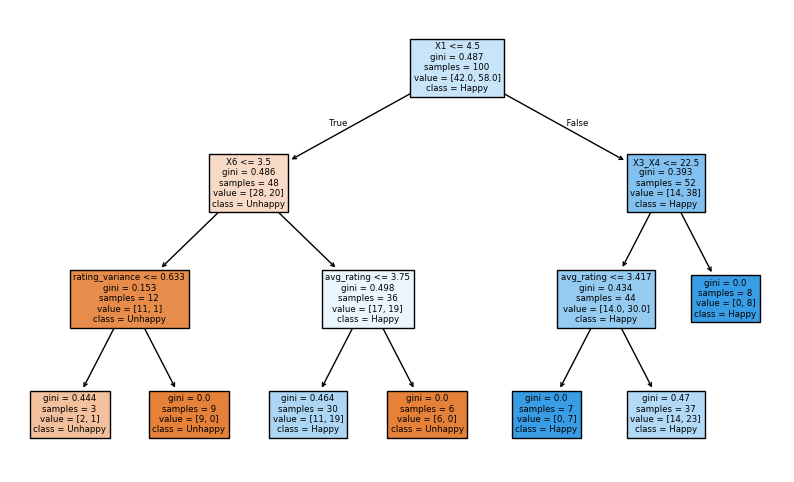

In [22]:
dt=DecisionTreeClassifier(max_depth=3, random_state=32)
dt.fit(X_train,y_train)
plt.figure(figsize=(10,6))

y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('The accuracy of the Decision Trees model on the test data is : {}:'.format(accuracy))
print('The F1 score of the Decision Trees model on the test data is : {}:'.format(f1))

tree.plot_tree(dt, feature_names=X_train.columns, class_names=['Unhappy', 'Happy'], filled=True)
plt.show()

Decision Trees showed higher accuracy and f1 score compared to the base Log Regression, but it's still not enough to hit our f1 score goal of 73%. Let's try to use GridSearch again to find the optimal hyperparameters for our model.

In [66]:
dt1=DecisionTreeClassifier(max_depth=3, random_state=32)
param_grid = {
    'max_depth': [2, 3, 4, 6, 8],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'criterion': ['gini', 'entropy']
}

grid_search=GridSearchCV(dt1, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X,y.values.ravel())

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'], zero_division=0)

print('Best parameters:', grid_search.best_params_)
print('Best CV f1 score:', grid_search.best_score_)
print("Classification Report for Best Model:")
print(report)

Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV f1 score: 0.6956360752186179
Classification Report for Best Model:
              precision    recall  f1-score   support

     Unhappy       0.71      0.33      0.45        15
       Happy       0.47      0.82      0.60        11

    accuracy                           0.54        26
   macro avg       0.59      0.58      0.53        26
weighted avg       0.61      0.54      0.52        26



Hyperparameter tuning increased our model f1 score, but it is slightly lower compared to our Log Regression model with tuned hyperparameters. Let's have a look at our feature importances for this model.

In [26]:
#Let's take a look at our feature importances
Feature_importance_rf1=pd.DataFrame({
    'Feature' : X.columns,
    'Coefficient' : grid_search.best_estimator_.feature_importances_
}).sort_values('Coefficient', ascending=False)
print(Feature_importance_rf1) 

            Feature  Coefficient
6             X1_X5     0.357477
0                X1     0.190448
5                X6     0.188309
9        avg_rating     0.142234
7             X3_X4     0.085057
10  rating_variance     0.036474
1                X2     0.000000
2                X3     0.000000
3                X4     0.000000
4                X5     0.000000
8             X2_X6     0.000000


Now let's try our final model for the data, which is K nearest neighbors (KNN), for which scaling the data is the first step. But, since all our features have the same range of values (1 to 5), it shouldn't affect the results significantly. <br/>
Anyway, let's try both options:

In [28]:
warnings.filterwarnings("ignore", message="X has feature names, but KNeighborsClassifier was fitted without feature names")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_scaled, y_train.values.ravel())

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('The accuracy of the KNN model on the test data is : {}:'.format(accuracy))
print('The F1 score of the KNN model on the test data is : {}:'.format(f1))

The accuracy of the KNN model on the test data is : 0.5:
The F1 score of the KNN model on the test data is : 0.5806451612903226:


The scaled KNN showed 50% accuracy and 58% f1 score, let's now try the same model without scaling:

In [30]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train.values.ravel())

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('The accuracy of the KNN model on the test data is : {}:'.format(accuracy))
print('The F1 score of the KNN model on the test data is : {}:'.format(f1))

The accuracy of the KNN model on the test data is : 0.5769230769230769:
The F1 score of the KNN model on the test data is : 0.56:


As it was expected, non-scaled model showed similar results compared to the scaled one.

Let's try Random Forest as the last model for our data.

In [33]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluation
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('The accuracy of the KNN model on the test data is : {}:'.format(accuracy))
print('The F1 score of the KNN model on the test data is : {}:'.format(f1))


The accuracy of the KNN model on the test data is : 0.5:
The F1 score of the KNN model on the test data is : 0.5517241379310345:


Now let's try to tune our hyperparameters for Random Forest.

In [68]:
rf1=RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

grid_search=GridSearchCV(rf1, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X,y.values.ravel())

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'], zero_division=0)


print('Best parameters:', grid_search.best_params_)
print('Best CV f1 score:', grid_search.best_score_)
print("Classification Report for Best Model:")
print(report)

Best parameters: {'class_weight': None, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV f1 score: 0.6978085957021489
Classification Report for Best Model:
              precision    recall  f1-score   support

     Unhappy       0.93      0.87      0.90        15
       Happy       0.83      0.91      0.87        11

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.89        26



# ???????

In [70]:
f1 = f1_score(y_test, y_pred)
print('The F1 score of the KNN model on the test data is : {}:'.format(f1))

The F1 score of the KNN model on the test data is : 0.8695652173913043:


In [36]:
#Let's take a look at our feature importances
Feature_importance_rf1=pd.DataFrame({
    'Feature' : X.columns,
    'Coefficient' : grid_search.best_estimator_.feature_importances_
}).sort_values('Coefficient', ascending=False)
print(Feature_importance_rf1) 

            Feature  Coefficient
6             X1_X5     0.161473
9        avg_rating     0.132462
7             X3_X4     0.123470
0                X1     0.102203
10  rating_variance     0.101251
8             X2_X6     0.086096
5                X6     0.080421
4                X5     0.067439
3                X4     0.060051
1                X2     0.043214
2                X3     0.041921


Both Random Forest and Decision Trees showed similar F1 scores of ~70%, while the Log Regression showed F1 score of ~71%. But Log Regression struggled with predicting the Unhappy customers, which are more valuable for the company, since they can point to the weak points of the company.

In Summary, two tree based models worked great on predicting whether the customer is happy or not, but Random Forest showed slightly better overall results.   <br/>


### Final model
__Random Forest__ <br/>
F1 score : ~ __66%__ <br/>
<br/>
<br/>
Additionally, based on feature importances of the previous models and the correlation matrix, we would recommend choosing paired features X1&X5, the average rating and paired features X3&X4 as the minimal set of features for predicting customer satisfaction with the service. Rating variance can also be added to the list. <br/>

### Final recommended  set of features <br/>
X1*X5 = my order was delivered on time __&__ I am satisfied with my courier <br/>
The average rating  <br/>
X3*X4 = I ordered everything I wanted __&__ I paid a good price for my order <br/>
The rating variance __(Optional)__ <br/>
